# Inferring Cosmo from PM Simulation

In [1]:
!hostname
!python -c "import jax; print(jax.default_backend(), jax.devices())"
# import jax; print(jax.__file__)
# !nvidia-smi

feynmangpu04.cluster.local


gpu [cuda(id=0)]


In [2]:
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.50' # NOTE: jax preallocates GPU (default 75%)

import matplotlib.pyplot as plt
import numpy as np
from getdist import plots, MCSamples

import jax
from jax import random
import jax.numpy as jnp
import jax_cosmo as jc
# import astropy.units as u

import numpyro
# numpyro.set_platform("gpu")
import numpyro.distributions as dist
from numpyro.handlers import seed, condition, trace

# from jax.experimental.ode import odeint
# import haiku as hk

# import diffrax
# from diffrax import diffeqsolve, ODETerm, Dopri5, LeapfrogMidpoint, PIDController, SaveAt

%matplotlib inline
%load_ext autoreload 
%autoreload 2

## Probabilistic Model

In [43]:
from jaxpm.growth import growth_rate
from jaxpm.painting import cic_paint



def get_rsd(cosmo, a, dx):
  v_pec = a**2 * growth_rate(cosmo, a) * jnp.sqrt(jc.background.Esqr(cosmo, a)) * dx
  # v_pec = growth_rate(cosmo, a) * dx
  drsd = jnp.zeros_like(v_pec)
  drsd[:,2] = v_pec[:,2]
  return drsd

In [47]:
from montecosmo.models import cosmo_prior, linear_pk_interp, linear_field
from jaxpm.pm import lpt
from jaxpm.painting import cic_paint
from jaxpm.growth import growth_rate


def forward_model(box_size, mesh_size, scale_factor_lpt, galaxy_density, trace_deterministic=False):
  """
  A forward model, where the relevant variables can be traced.
  """
  # Sample cosmology
  cosmology = cosmo_prior(trace_deterministic=True)

  # Sample initial conditions
  pk_fn = linear_pk_interp(cosmology, n_interp=256)
  init_mesh = linear_field(mesh_size, box_size, pk_fn)
  if trace_deterministic:
    init_mesh = numpyro.deterministic('init_mesh', init_mesh)

  # Create regular grid of particles
  particles_pos = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in mesh_size]),axis=-1).reshape([-1,3])
  
  # Initial displacement with LPT
  cosmology._workspace = {}  # FIXME: this a temporary fix
  dx, p, f = lpt(cosmology, init_mesh, particles_pos, a=scale_factor_lpt)
  # NOTE: lpt supposes given mesh follows linear pk at a=1, and correct by growth factor to get forces at wanted scale factor.
  particles_pos = particles_pos + dx



  drsd = get_rsd(cosmology, scale_factor_lpt, dx)

  # Cloud In Cell painting
  lpt_mesh = cic_paint(jnp.zeros(mesh_size), particles_pos)
  rsd_mesh = cic_paint(jnp.zeros(mesh_size), drsd)
  bias = numpyro.sample('bias', dist.Normal(2, 0.25))

  mesh_obs = bias * lpt_mesh + rsd_mesh
  # if trace_deterministic:
  #   lpt_mesh = numpyro.deterministic('lpt_mesh', lpt_mesh)

  # Observe
  ## Direct observation
  # mesh_obs = numpyro.sample('lpt_mesh_obs', dist.Delta(lpt_mesh))
  ## Normal noise 
  # mesh_obs = numpyro.sample('lpt_mesh_obs', dist.Normal(lpt_mesh, 0.1))
  ## Poisson noise
  # gxy_intens_mesh = (lpt_mesh + 1) * (galaxy_density * box_size.prod() / mesh_size.prod())
  # mesh_obs = numpyro.sample('lpt_mesh_obs', dist.Poisson(gxy_intens_mesh))
  return mesh_obs

In [48]:
# Model params
model_kwargs = {}

## Mesh and box parameters
mesh_length = 64 # 64
box_length = 640 # in Mpc/h (aim for cell lengths between 1 and 10 Mpc/h)
model_kwargs['mesh_size'] = np.array([mesh_length, mesh_length, mesh_length])
model_kwargs['box_size'] = np.array([box_length, box_length, box_length])  # in Mpc/h

## Scale factor
model_kwargs['scale_factor_lpt'] = 0.1

## Galaxies
model_kwargs['galaxy_density'] = 1e-3 # in galaxy / (Mpc/h)^3

## Debugging
model_kwargs['trace_deterministic'] = True

In [49]:
# Print infos
cell_lengths = list( model_kwargs['box_size'] / model_kwargs['mesh_size'] )
print(f"{cell_lengths=} Mpc/h")

k_nyquist = 2 * jnp.pi * jnp.min(model_kwargs['mesh_size'] / model_kwargs['box_size']) / 2
delta_k = 2 * jnp.pi * jnp.min(1 / model_kwargs['box_size']) 
# (2\pi factor because of Fourier transform definition)
print(f"{k_nyquist=:.5f} h/Mpc, {delta_k=:.5f} h/Mpc")

mean_galaxy_cell_intensity = model_kwargs['galaxy_density'] * model_kwargs['box_size'].prod() / model_kwargs['mesh_size'].prod()
print(f"{mean_galaxy_cell_intensity=:.3f} galaxy/cell")

# Render model
numpyro.render_model(model=forward_model, model_kwargs=model_kwargs, render_distributions=True, render_params=True)

cell_lengths=[10.0, 10.0, 10.0] Mpc/h
k_nyquist=0.31416 h/Mpc, delta_k=0.00982 h/Mpc
mean_galaxy_cell_intensity=1.000 galaxy/cell


/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


ValueError: vmap was requested to map its argument along axis 0, which implies that its rank should be at least 1, but is only 0 (its shape is ())

## Simulate

In [6]:
# Cosmological parameters
cosmo_var_names = ['Omega_c', 'sigma8']
cosmo_var_labels = [r'\Omega_c', r'\sigma_8']
# TODO: dict name:(mean, var) or (min,max) for cosmo_prior?

# Condition model on some cosmology and sample
fiducial_cosmo_params_base = {var_name+"_base": 0. for var_name in cosmo_var_names}
fiducial_model = condition(forward_model, fiducial_cosmo_params_base) # NOTE: Only condition on random sites, not deterministic ones

# Get trace
fiducial_model_trace = trace(seed(fiducial_model, rng_seed=0)).get_trace(**model_kwargs)
# Check cosmology
fiducial_cosmo_params = {var_name: fiducial_model_trace[var_name]['value'] for var_name in cosmo_var_names}
fiducial_cosmology = jc.Planck15(**fiducial_cosmo_params)
print(f"Fiducial {fiducial_cosmology}")

/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


Fiducial Cosmological parameters: 
    h:        0.6774 
    Omega_b:  0.0486 
    Omega_c:  0.25 
    Omega_k:  0.0 
    w0:       -1.0 
    wa:       0.0 
    n:        0.9667 
    sigma8:   0.831


## Power spectra

In [7]:
from jaxpm.utils import power_spectrum
from montecosmo.utils import cic_compensate

# Get meshes from model trace
init_mesh, lpt_mesh = fiducial_model_trace['init_mesh']['value'], fiducial_model_trace['lpt_mesh']['value']

# Compute power spectra
pk_lin_init = linear_pk_interp(fiducial_cosmology)
pk_init = power_spectrum(init_mesh, kmin=0.001, dk=0.01, boxsize=model_kwargs['box_size'])

pk_lin_lpt = linear_pk_interp(fiducial_cosmology, scale_factor=model_kwargs['scale_factor_lpt'])
lpt_comp_mesh = cic_compensate(lpt_mesh) # compensate for CIC painting convolution
pk_lpt = power_spectrum(lpt_comp_mesh, kmin=0.001, dk=0.01, boxsize=model_kwargs['box_size'])

/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/lax/lax.py:513: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


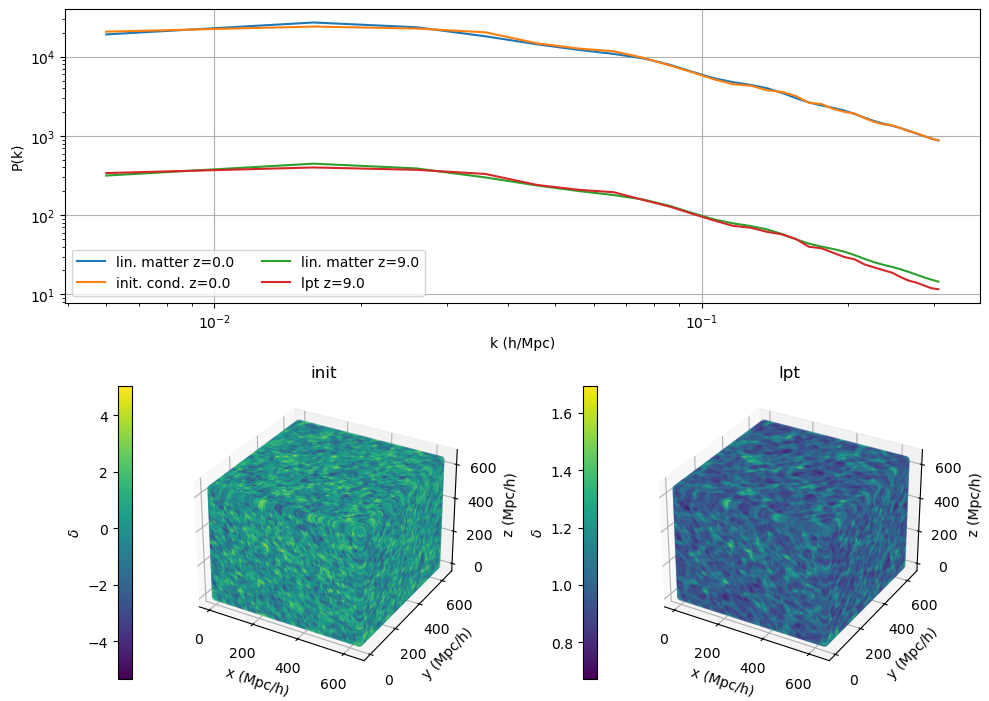

In [8]:
plt.figure(figsize=(10,7))
plt.subplot(211)
plt.loglog(pk_init[0], pk_lin_init(pk_init[0]), label=f"lin. matter z={1/1-1}")
plt.loglog(pk_init[0], pk_init[1], label=f"init. cond. z={1/1-1}")
plt.loglog(pk_init[0], pk_lin_lpt(pk_init[0]), label=f"lin. matter z={1/model_kwargs['scale_factor_lpt']-1}")
plt.loglog(pk_lpt[0], pk_lpt[1], label=f"lpt z={1/model_kwargs['scale_factor_lpt']-1}")
plt.grid(), plt.legend(ncols=2), plt.xlabel("k (h/Mpc)"), plt.ylabel("P(k)")

# # xx, yy, zz = np.indices(cmb_mesh.shape) # to get indices
xx, yy, zz = np.mgrid[[slice(0,box_length,init_mesh.shape[i]*1j) 
                       for i, box_length in enumerate(model_kwargs['box_size'])]] # to get distances
init_color = init_mesh.flatten()
lpt_color = lpt_mesh.flatten()
cmap = plt.colormaps['viridis']

ax3D = plt.subplot(223, projection='3d')
p3d = ax3D.scatter(xx, yy, zz, marker ="o", c=init_color, cmap=cmap)
ax3D.set_xlabel("x (Mpc/h)"), ax3D.set_ylabel("y (Mpc/h)"), ax3D.set_zlabel("z (Mpc/h)")
plt.colorbar(p3d, location='left').set_label(r"$\delta$")
plt.title("init")

ax3D = plt.subplot(224, projection='3d')
p3d = ax3D.scatter(xx, yy, zz, marker ="o", c=lpt_color, cmap=cmap)
ax3D.set_xlabel("x (Mpc/h)"), ax3D.set_ylabel("y (Mpc/h)"), ax3D.set_zlabel("z (Mpc/h)")
plt.colorbar(p3d, location='left').set_label(r"$\delta$")
plt.title("lpt")

plt.tight_layout(), plt.show();

## Inference

In [7]:
# Condition model
obs_var_names = ['lpt_mesh_obs'] # NOTE: Only condition on random sites
obs_values = {var_name: fiducial_model_trace[var_name]['value'] for var_name in obs_var_names}
observed_model = condition(forward_model, obs_values)  

# Initialize sampler
init_var_names = ['Omega_c_base', 'sigma8_base', 'init_mesh_base'] # NOTE: Only init on random sites
init_values = {var_name: fiducial_model_trace[var_name]['value'] for var_name in init_var_names}

# # Load some inverse mass matrix
# with open(save_path+f"_invM.p", 'rb') as file:
#     variance_as_invM = pickle.load(file)

# nuts_kernel = numpyro.infer.NUTS(
#     model=observed_model,
#     init_strategy=numpyro.infer.init_to_value(values=init_values),
#     max_tree_depth=5, # 3
#     # inverse_mass_matrix=variance_as_invM, 
#     # adapt_mass_matrix=False,
#     dense_mass=[('Omega_c_base', 'sigma8_base')], # NOTE: dense matrix for cosmo params joint, diagonal for the rest
#     # step_size=0.01, 
#     # adapt_step_size=False,
#     )

nuts_kernel = numpyro.infer.HMC(
    model=observed_model,
    init_strategy=numpyro.infer.init_to_value(values=init_values),
    # num_steps=32,
    # adapt_mass_matrix=False,
    # step_size=0.01, 
    # adapt_step_size=False,
    )

mcmc = numpyro.infer.MCMC(
       nuts_kernel,
       num_warmup=1000,
       num_samples=1000, # for each run
    #    chain_method="vectorized", 
    #    num_chains=8,
       progress_bar=True
       )

In [9]:
import pickle
# Variables to save
save_var_names = cosmo_var_names + ['Omega_c_base', 'sigma8_base', 'init_mesh']
# Saves directory
save_directory = os.path.expanduser("~/scratch/npys/") # or in "~/work/npys/"
save_name = "obs_lpt64__warmup_free__HMC"
save_path = os.path.join(save_directory, save_name)
# save_path = os.path.join(save_directory, save_name, save_name)
# Number of runs
n_runs = 2

In [10]:
from montecosmo.utils import sample_and_save
mcmc_runned = sample_and_save(mcmc, model_kwargs, n_runs, save_path, save_var_names)

run 0/2 (warmup)


  0%|          | 0/1000 [00:00<?, ?it/s]/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)
warmup:   1%|          | 11/1000 [12:07<20:40:59, 75.29s/it, 629 steps of size 1.31e-02. acc. prob=0.61] 

In [ ]:
from montecosmo.utils import sample_and_save
mcmc_runned = sample_and_save(mcmc, model_kwargs, n_runs, save_path, save_var_names)

run 0/2 (warmup)


  0%|          | 0/1000 [00:00<?, ?it/s]/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)
warmup: 100%|██████████| 1000/1000 [26:41<00:00,  1.60s/it, 32 steps of size 1.18e-38. acc. prob=0.34]
/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X6

run 1/2


sample: 100%|██████████| 1000/1000 [25:48<00:00,  1.55s/it, 32 steps of size 1.18e-38. acc. prob=0.00]


run 2/2


sample:  19%|█▊        | 187/1000 [04:52<21:13,  1.57s/it, 32 steps of size 1.18e-38. acc. prob=0.00]


KeyboardInterrupt: 

In [ ]:
from montecosmo.utils import sample_and_save
mcmc_runned = sample_and_save(mcmc, model_kwargs, n_runs, save_path, save_var_names)

run 0/2 (warmup)


/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)
  0%|          | 0/500 [00:00<?, ?it/s]/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getat

run 1/2


sample: 100%|██████████| 1000/1000 [37:49<00:00,  2.27s/it, 31 steps of size 3.37e-02. acc. prob=0.82]
/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


dict_keys(['Omega_c', 'Omega_c_base', 'init_mesh', 'init_mesh_base', 'lpt_mesh', 'sigma8', 'sigma8_base'])
run 2/2


sample: 100%|██████████| 1000/1000 [35:41<00:00,  2.14s/it, 31 steps of size 3.37e-02. acc. prob=0.82]


dict_keys(['Omega_c', 'Omega_c_base', 'init_mesh', 'init_mesh_base', 'lpt_mesh', 'sigma8', 'sigma8_base'])


## Analysis

In [45]:
from montecosmo.utils import load_runs

print(f"loading: {save_name}")
start_run, end_run = 0, 2
# Load only cosmological samples
cosmo_post_samples = load_runs(cosmo_var_names, save_path, start_run, end_run)
cosmo_post_samples_arr = np.array(list(cosmo_post_samples.values())).T
# Load saved samples
post_samples = load_runs(save_var_names, save_path, start_run, end_run)

loading: obs_lpt64__warmup_freedensecosmo1000__treedep_5
total num samples=3000
total num samples=3000


### Chain

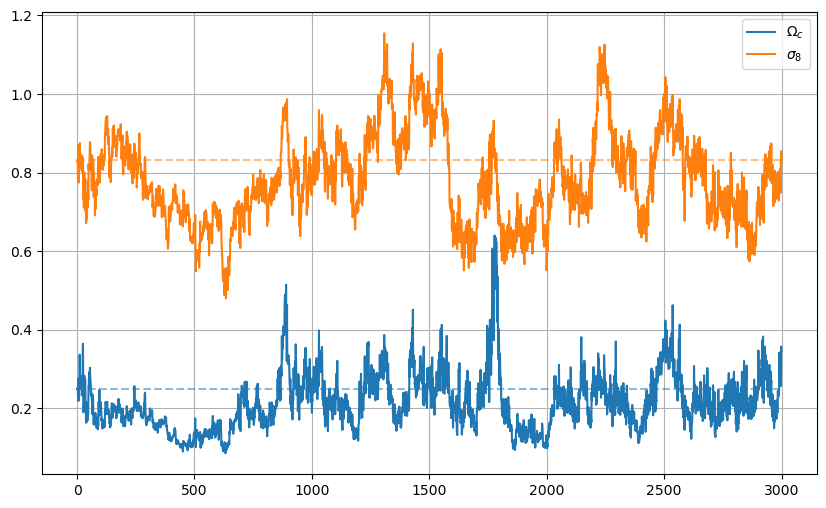

In [30]:
# Plot chain
plt.figure(figsize=(10,6))
plt.plot(cosmo_post_samples_arr, label=["$"+label+"$" for label in cosmo_var_labels])
plt.hlines(fiducial_cosmo_params.values(), 
           xmin=0, xmax=len(cosmo_post_samples_arr), 
           ls="--", alpha=0.5,
           color=["C"+str(i) for i in range(len(cosmo_post_samples_arr))],)
plt.legend(), plt.grid(), 
plt.savefig(save_path+"_chain")
plt.show()

Removed no burn in
Removed no burn in


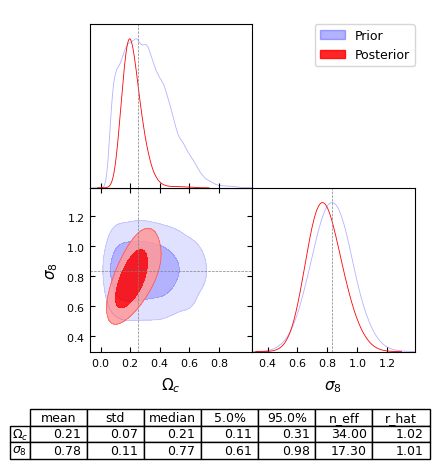

In [31]:
# Diagnostics
# numpyro.diagnostics.print_summary(cosmo_post_samples, group_by_chain=False) # NOTE: group_by_chain if several chains
summary_dic = numpyro.diagnostics.summary(cosmo_post_samples, group_by_chain=False) # NOTE: group_by_chain if several chains
summary_arr = [list(list(summary_dic.values())[i].values()) for i in range(len(summary_dic.values()))]

# Define a custom formatting function to vectorize on summary array
def format_value(value):
    return f"{value:0.2f}"

# Sample from prior
def cosmo_prior_plate(plate_size):
    with numpyro.plate('cosmo_prior_plate', plate_size):
        cosmo_prior(trace_deterministic=True)

plate_size = 10000
cosmo_prior_trace = trace(seed(cosmo_prior_plate, 0)).get_trace(plate_size)
cosmo_prior_samples_arr = np.array([cosmo_prior_trace[key]['value'] for key in cosmo_var_names]).T

# Triangle plot
post_samples_gd = MCSamples(samples=cosmo_post_samples_arr, names=cosmo_var_names, labels=cosmo_var_labels)
prior_samples_gd = MCSamples(samples=cosmo_prior_samples_arr, names=cosmo_var_names, labels=cosmo_var_labels)
gd = plots.get_subplot_plotter(subplot_size=None)
# gd.settings.solid_colors='tab10_r'
gd.triangle_plot(roots=[prior_samples_gd, post_samples_gd],
                 markers=fiducial_cosmo_params,
                 filled=True, 
                 legend_labels=["Prior", "Posterior"],
                 line_args=[{'color':'b', 'alpha':0.3},{'color':'r'}],
                 contour_args=[{'color':'b', 'alpha':0.3},{'color':'r'}],)

# Plot summary table
plt.subplot(position=[0,0,1,1]), plt.axis('off')
# gd.fig.axes[-1]('tight'), plt.axis('tight'), plt.subplots_adjust(top=2), plt.gcf().patch.set_visible(False), 
plt.table(cellText=np.vectorize(format_value)(summary_arr),
            # rowLabels=list(summary_dic.keys()),
            rowLabels=["$"+label+"$" for label in cosmo_var_labels], 
            colLabels=list(list(summary_dic.values())[0].keys()),)
plt.savefig(save_path+"_triangle", bbox_inches='tight') # NOTE: tight bbox required to save table
plt.show();

### Mass matrix

In [52]:
# Load mass matrix
with open(save_path+f"_laststate.p", 'rb') as file:
    last_state = pickle.load(file)
    
inverse_mass_matrix = last_state.adapt_state.inverse_mass_matrix
inverse_mass_matrix

{('Omega_c_base',
  'sigma8_base'): Array([[0.26130238, 0.28251714],
        [0.28251714, 0.4265198 ]], dtype=float32),
 ('init_mesh_base',): Array([1.0277663 , 0.91260546, 0.7436735 , ..., 0.9586785 , 1.4398409 ,
        1.1916659 ], dtype=float32)}

In [53]:
np.cov(np.array([post_samples[var_name] for var_name in ['Omega_c_base', 'sigma8_base']]))

array([[0.12567624, 0.1759004 ],
       [0.1759004 , 0.66985823]])

In [ ]:
# Plot inverse mass matrix vs. posterior sample variance
invM_arr = np.array(list(inverse_mass_matrix.values()))[0] # also jax.tree_util.tree_flatten(inverse_mass_matrix)[0][0]
var_names = list(inverse_mass_matrix.keys())[0]

post_variance_mesh, post_variance_cosmo = [], []
invM_mesh, invM_cosmo, invM_cosmo_name = [], [], []
invM_head = 0
for var_name in var_names:
    var_variance = post_samples[var_name].var(axis=0).flatten()
    new_invM_head = invM_head + len(var_variance)
    if var_name in ['init_mesh_base']:
        post_variance_mesh = np.concatenate((post_variance_mesh, var_variance))
        invM_mesh = np.concatenate((invM_mesh, invM_arr[invM_head: new_invM_head]))
    else:
        post_variance_cosmo = np.concatenate((post_variance_cosmo, var_variance))
        invM_cosmo = np.concatenate((invM_cosmo, invM_arr[invM_head: new_invM_head]))
        invM_cosmo_name += [var_name]
    invM_head = new_invM_head


plt.figure(figsize=(14,4))
plt.subplot(1,5,(1,2))
x_pos = np.arange(len(invM_cosmo))
plt.bar(x_pos, invM_cosmo, width=.5, label="inverse mass")
plt.bar(x_pos+.4, post_variance_cosmo, width=.5, label="sample var")
plt.xticks(x_pos+.2, invM_cosmo_name)
plt.legend(), plt.grid()

plt.subplot(1,5,(3,5))
# argsort_invM_mesh = np.argsort(invM_mesh) 
# plt.plot(invM_mesh[argsort_invM_mesh][::-1], label="inverse mass")
# plt.plot(post_variance_mesh[argsort_invM_mesh][::-1], label="sample var")
argsort_postvar_mesh = np.argsort(post_variance_mesh) 
plt.plot(invM_mesh[argsort_postvar_mesh][::-1], label="inverse mass")
plt.plot(post_variance_mesh[argsort_postvar_mesh][::-1], label="sample var")
plt.xlabel("init_mesh_base")
plt.legend(), plt.tight_layout(), plt.grid()
plt.savefig(save_path+"_invMvar");

FileNotFoundError: [Errno 2] No such file or directory: '/feynman/home/dphp//hs276503/scratch/npys/obs_lpt64__warmup_varasinvM500__treedep_5_laststate.p'

In [ ]:
# Save posterior variance as inverse mass matrix format
post_variance = []
for var_name in var_names:
    if var_name == 'init_mesh_base':
        var_name = 'init_mesh'
        post_variance = np.concatenate((post_variance, np.ones(post_samples[var_name][0].flatten().shape)))
    else:
        post_variance = np.concatenate((post_variance, post_samples[var_name].var(axis=0).flatten()))
        post_variance = np.concatenate((post_variance, ))
variance_as_invM = {var_names: post_variance}
print(variance_as_invM)

# with open(save_path+f"_invM.p", 'wb') as file:
#     pickle.dump(post_variance, file, protocol=pickle.HIGHEST_PROTOCOL)

NameError: name 'var_names' is not defined

### Init. cond. 

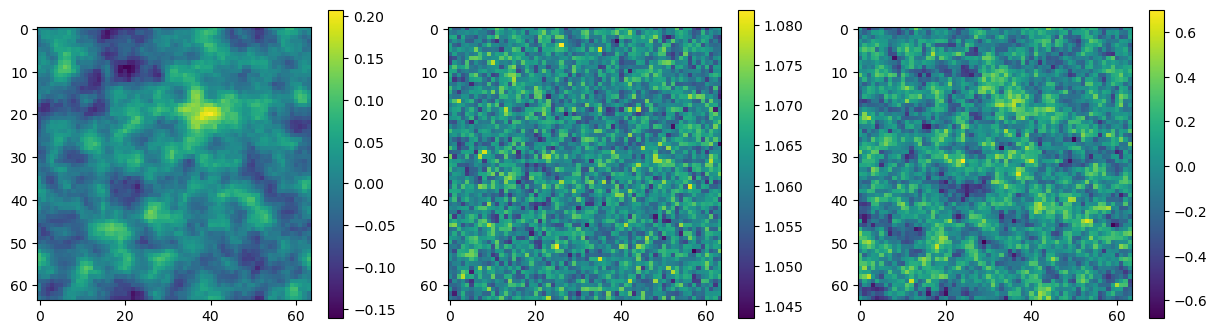

In [32]:
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.imshow(post_samples['init_mesh'].mean(0).mean(0)), plt.colorbar()
plt.subplot(132)
plt.imshow(post_samples['init_mesh'].std(0).mean(0)), plt.colorbar()
plt.subplot(133)
plt.imshow(fiducial_model_trace['init_mesh']['value'].mean(0)), plt.colorbar()
plt.show();

### Spectrum distribution

In [33]:
n_pks = 1000
pks = np.empty((n_pks, *pk_init[1].shape))
for i_sample in range(n_pks):
    mesh = post_samples['init_mesh'][-i_sample]
    _, pks[i_sample] = power_spectrum(mesh, kmin=0.001, dk=0.01, boxsize=model_kwargs['box_size'])

pk_023, pk_159, pk_500, pk_841, pk_977 = np.quantile(pks, q=[0.023, 0.159, 0.5, 0.841, 0.977], axis=0)

/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/lax/lax.py:513: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


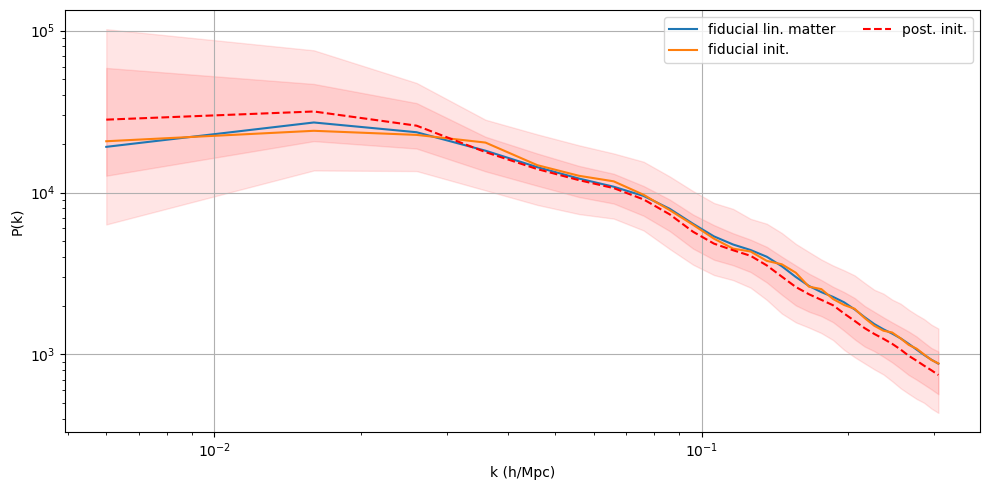

In [34]:
plt.figure(figsize=(10,5))
plt.subplot(111)
plt.loglog(pk_init[0], pk_lin_init(pk_init[0]), label=f"fiducial lin. matter")
plt.loglog(pk_init[0], pk_init[1], label=f"fiducial init.")
plt.loglog(pk_init[0], pk_500, color='red', ls='--', label=f"post. init.")
plt.fill_between(pk_init[0], pk_159, pk_841, alpha=0.1, color='red')
plt.fill_between(pk_init[0], pk_023, pk_977, alpha=0.1, color='red')
plt.legend(ncols=2), plt.xlabel("k (h/Mpc)"), plt.ylabel("P(k)")
plt.grid(), plt.tight_layout()
plt.savefig(save_path+"_Pkdist");

### Joint density

In [ ]:
from numpyro.infer.util import log_density

box = np.array([[-2.5, 2.5], [-2.5, 2.5]])
xx, yy = np.mgrid[[slice(box_ax[0],box_ax[1],30*1j) 
                       for box_ax in box]] # to get distances
# field = numpyro.sample('init_mesh_base', dist.Normal(jnp.zeros(mesh_size), jnp.ones(mesh_size)))

zz = jnp.array([[log_density(forward_model, 
                             (), 
                             model_kwargs, 
                             {'Omega_c_base':xx_ij, 
                              'sigma8_base':yy_ij, 
                              'init_mesh_base':init_values['init_mesh_base'],
                              'lpt_mesh_obs':obs_values['lpt_mesh_obs'],
                              }
                             )[0] for xx_ij, yy_ij in zip(xx_i, yy_i)] for xx_i, yy_i in zip(xx, yy)])
print(zz.shape)

(2, 2)


In [ ]:
np.save(save_path+"_zz", zz)

In [ ]:
plt.figure(figsize=(10,6))
ax3D = plt.subplot(111)
p3d = ax3D.pcolormesh(xx, yy, jnp.exp(zz), cmap='viridis')
ax3D.set_xlabel("x (Mpc/h)"), ax3D.set_ylabel("y (Mpc/h)")
plt.colorbar(p3d)
plt.save(save_path+"_postslice")
plt.show();

# Tail